# Diffusion across a circular domain

In [16]:
doPlotInline = True
import fipy as fi
import numpy as np
from scipy.special import erf 
import localGraphing as lg
%matplotlib osx
if doPlotInline:
    %matplotlib inline
lg.closeAll()
lg.setParams(doPlotInline)

Solve the diffusion equation in a circular domain meshed with triangles.

This example demonstrates how to solve a simple diffusion problem on a
non-standard mesh with varying boundary conditions. The `Gmsh` package
is used to create the mesh. Firstly, define some parameters for the
creation of the mesh,

In [17]:
cellSize = 0.05
radius = 1.

The `cellSize` is the preferred edge length of each mesh element and
the `radius` is the radius of the circular mesh domain. In the
following code section a file is created with the geometry that
describes the mesh. For details of how to write such geometry files
for `Gmsh`, see the Gmsh manual:

 http://www.geuz.org/gmsh/doc/texinfo/gmsh.html

The mesh created by `Gmsh` is then imported into `FiPy` using the
`Gmsh2D` object.

In [18]:
mesh = fi.Gmsh2D('''
              cellSize = %(cellSize)g;
              radius = %(radius)g;
              Point(1) = {0, 0, 0, cellSize};
              Point(2) = {-radius, 0, 0, cellSize};
              Point(3) = {0, radius, 0, cellSize};
              Point(4) = {radius, 0, 0, cellSize};
              Point(5) = {0, -radius, 0, cellSize};
              Circle(6) = {2, 1, 3};
              Circle(7) = {3, 1, 4};
              Circle(8) = {4, 1, 5};
              Circle(9) = {5, 1, 2};
              Line Loop(10) = {6, 7, 8, 9};
              Plane Surface(11) = {10};
              ''' % locals()) 

Using this mesh, we can construct a solution variable

In [19]:
phi = fi.CellVariable(name = "$T$", mesh = mesh, value = 0.)

We can now create a viewer to see the mesh

In [20]:
graphTitle = '$T(x,y;t=0)$'
axisLabels = ('$x$','$y$')
limits={'datamin': -1.0, 'datamax': 1.0}

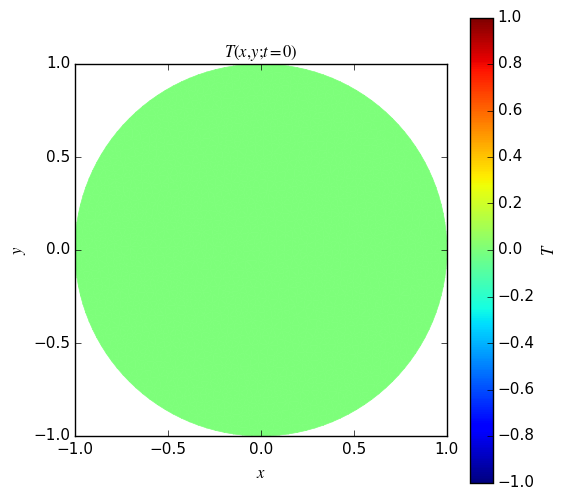

In [21]:
viewer1 = lg.createViewer(graphTitle, (phi), axisLabels,limits )
viewer1.axes.set_aspect(1)
# viewer1.plotMesh()

We set up a transient diffusion equation

In [22]:
D = 1.
eq = fi.TransientTerm() == fi.DiffusionTerm(coeff=D)

The following line extracts the $x$ coordinate values on the exterior
faces. These are used as the boundary condition fixed values.

In [23]:
X, Y = mesh.faceCenters
phi.constrain(X, mesh.exteriorFaces)

We first step through the transient problem

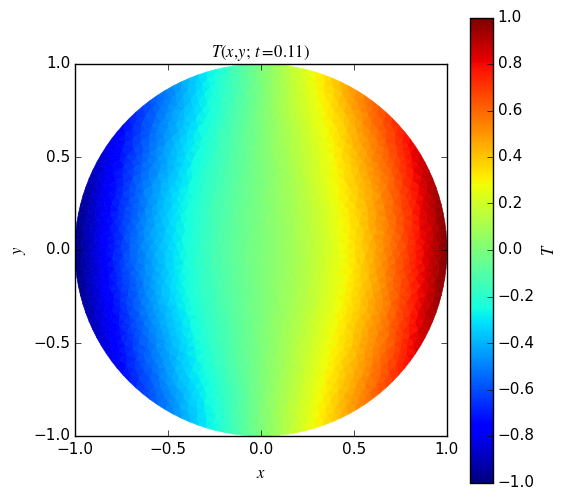

In [24]:
deltaTime = 10 * 0.9 * cellSize**2 / (2 * D)
steps = 10
simTime = 0
for step in range(steps):
    simTime += deltaTime
    eq.solve(var=phi, dt=deltaTime)
    graphTitle='$T(x,y;\,t=%g)$' %np.round(simTime,2)
    if not(doPlotInline):
        viewer1.axes.set_title(graphTitle)
        viewer1.plot()
if (doPlotInline):
    viewer1b = lg.createViewer(graphTitle, (phi), axisLabels,limits )
    viewer1b.axes.set_aspect(1)

       
-----

This problem again has an analytical solution that depends on the error
function, but it's a bit more complicated due to the varying boundary
conditions and the different horizontal diffusion length at different
vertical positions

In [25]:
x, y = mesh.cellCenters
t = deltaTime * steps

In [26]:
phiAnalytical = fi.CellVariable(name="analytical value", mesh=mesh)

In [27]:
x0 = radius * fi.numerix.cos(fi.numerix.arcsin(y))
phiAnalytical.setValue(x0 * (erf((x0+x) / (2*fi.numerix.sqrt(D * t))) 
                             - erf((x0-x) / (2*fi.numerix.sqrt(D * t)))))
print(phi.allclose(phiAnalytical, atol = 7e-2))

True


-----

As in the earlier examples, we can also directly solve the steady-state
diffusion problem.

In [28]:
fi.DiffusionTerm(coeff=D).solve(var=phi)

                                                 
The values at the elements should be equal to their `x` coordinate

In [29]:
print(phi.allclose(x, atol = 0.03))

True


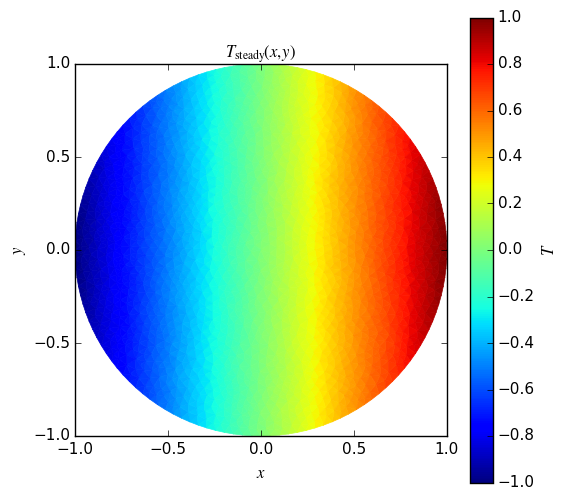

In [30]:
graphTitle = '$T_\mathrm{steady}(x,y)$'
viewer2 = lg.createViewer(graphTitle, (phi), axisLabels,limits)
viewer2.axes.set_aspect(1)
viewer2.plot()